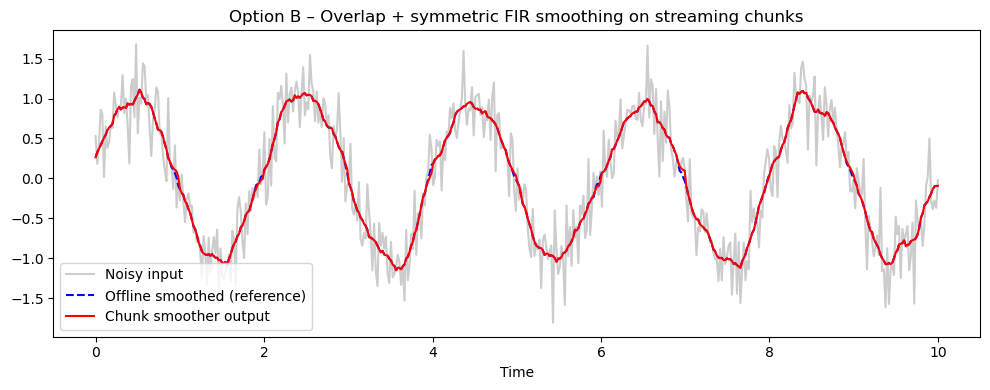

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian

# === The chunk smoother from Option B ===
class ChunkSmoother:
    def __init__(self, kernel: np.ndarray, dim: int):
        self.kernel = kernel / kernel.sum()
        self.W = len(kernel)
        self.H = (self.W - 1) // 2
        self.history_tail = None
        self.dim = dim

    def process(self, x_new: np.ndarray) -> np.ndarray:
        x_new = np.asarray(x_new, dtype=np.float64)
        if x_new.ndim == 1:
            x_new = x_new[:, None]
        L, D = x_new.shape
        assert D == self.dim

        # 1) add left context
        if self.history_tail is None:
            x_ext = x_new
        else:
            x_ext = np.vstack([self.history_tail, x_new])

        # 2) convolution (same length)
        y_ext = np.empty_like(x_ext)
        for d in range(D):
            y_ext[:, d] = np.convolve(x_ext[:, d], self.kernel, mode="same")

        # 3) discard old part
        if self.history_tail is None:
            y_new = y_ext
        else:
            y_new = y_ext[self.history_tail.shape[0]:]

        # 4) update tail (raw data)
        if L >= self.H:
            self.history_tail = x_new[-self.H:].copy()
        else:
            self.history_tail = x_new.copy()

        return y_new


# === Simulated input signal ===
np.random.seed(0)
t = np.linspace(0, 10, 500)
signal = np.sin(2 * np.pi * 0.5 * t) + 0.3 * np.random.randn(len(t))

# === Create smoother ===
kernel = gaussian(11, std=5.0)  # symmetric, zero-phase kernel
smoother = ChunkSmoother(kernel, dim=1)

# === Stream the signal in chunks ===
chunk_size = 50
smoothed_chunks = []
for i in range(0, len(signal), chunk_size):
    x_chunk = signal[i:i + chunk_size]
    y_chunk = smoother.process(x_chunk)
    smoothed_chunks.append(y_chunk)

y_stream = np.vstack(smoothed_chunks).flatten()

# === Reference: offline smoothing for comparison ===
kernel_full = kernel / kernel.sum()
y_offline = np.convolve(signal, kernel_full, mode="same")

# === Plot ===
plt.figure(figsize=(10, 4))
plt.plot(t, signal, color='gray', alpha=0.4, label='Noisy input')
plt.plot(t, y_offline, 'b--', label='Offline smoothed (reference)')
plt.plot(t, y_stream, 'r', label='Chunk smoother output')
plt.legend()
plt.title("Option B – Overlap + symmetric FIR smoothing on streaming chunks")
plt.xlabel("Time")
plt.tight_layout()
plt.show()
